# **TASK 2: SPAM SMS DETECTION**
[Kaggle Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)

In [1]:
import nltk
import spacy
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
df=pd.read_csv('/content/spam.csv',encoding="ISO-8859-1")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
df=df[['v1','v2']]

In [5]:
column_mapping = {'v1': 'label',
                  'v2': 'message'}

df = df.rename(columns=column_mapping)

In [6]:
df.shape

(5572, 2)

In [7]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Data Cleaning

In [8]:
# Tokenization
df['tokens'] = df['message'].apply(word_tokenize)

# Removing Stop Words
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 46.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
# Removing Stop Words
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

# Join tokens into a single string
df['tokens'] = df['tokens'].apply(lambda x: ' '.join(x))

# Lemmatization
nlp = spacy.load('en_core_web_sm')

def lemmatize_text_spacy(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc]

df['tokens'] = df['tokens'].apply(lemmatize_text_spacy)

In [10]:
df['message']=df['tokens'].apply(lambda x: ' '.join(x))
df.head()

,label,message,tokens
0,ham,"go jurong point , crazy .. available bugis n g...","[go, jurong, point, ,, crazy, .., available, b..."
1,ham,ok lar ... joke wif u oni ...,"[ok, lar, ..., joke, wif, u, oni, ...]"
2,spam,free entry 2 wkly comp win FA Cup final tkts 2...,"[free, entry, 2, wkly, comp, win, FA, Cup, fin..."
3,ham,u dun say early hor ... u c already say ...,"[u, dun, say, early, hor, ..., u, c, already, ..."
4,ham,"Nah not think go usf , live around though","[Nah, not, think, go, usf, ,, live, around, th..."


In [12]:
df.describe()

,label,message,tokens
count,5572,5572,5572
unique,2,5147,5147
top,ham,"sorry , will call later","[sorry, ,, will, call, later]"
freq,4825,30,30


# Exploratory Data Analysis (EDA)

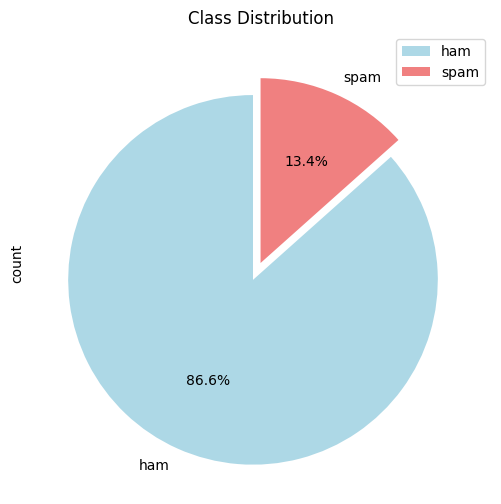

In [13]:
class_distribution = df['label'].value_counts()

plt.figure(figsize=(8, 6))
class_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=90, explode=(0.1, 0), colors=['lightblue', 'lightcoral'])
plt.title('Class Distribution')


plt.legend(labels=class_distribution.index, loc="best")

plt.show()


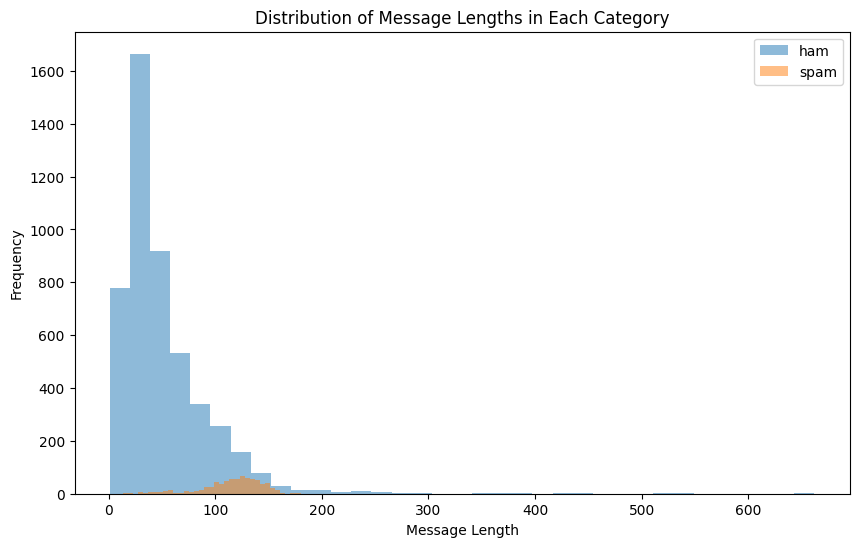

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [14]:
plt.figure(figsize=(10, 6))
df['message_length'] = df['message'].apply(len)
df.groupby('label')['message_length'].plot(bins=35 ,kind='hist', alpha=0.5, legend=True)
plt.xlabel('Message Length')
plt.title('Distribution of Message Lengths in Each Category')
plt.show()

plt.figure(figsize=(12, 8))

<Figure size 800x600 with 0 Axes>

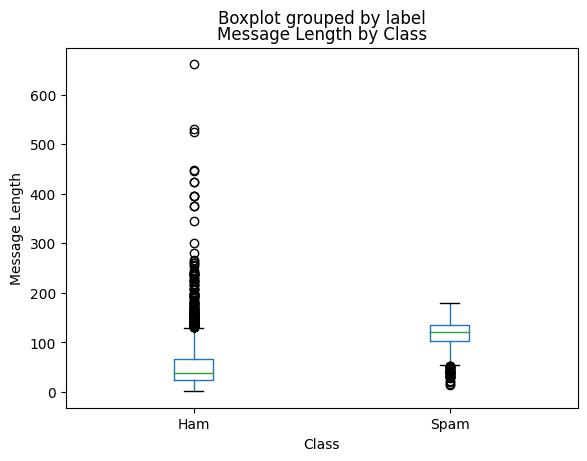

In [15]:
plt.figure(figsize=(8, 6))
df.boxplot(column='message_length', by='label', grid=False)
plt.title('Message Length by Class')
plt.xlabel('Class')
plt.ylabel('Message Length')
plt.xticks([1, 2], ['Ham', 'Spam'])
plt.show()

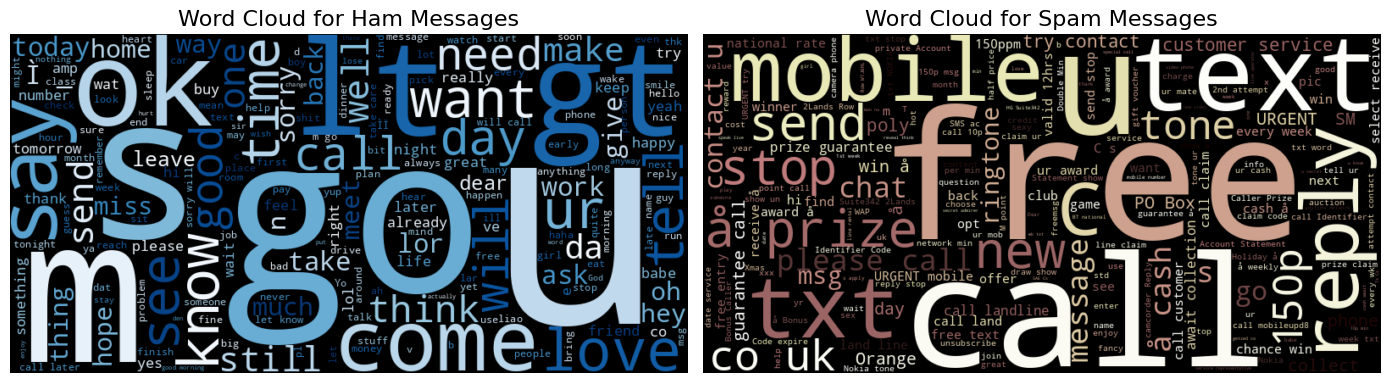

In [16]:
ham_words = ' '.join(df[df['label'] == 'ham']['message'])
spam_words = ' '.join(df[df['label'] == 'spam']['message'])


wordcloud_ham = WordCloud(width=800, height=400, colormap='Blues').generate(ham_words)
wordcloud_spam = WordCloud(width=800, height=400, colormap='pink').generate(spam_words)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.title('Word Cloud for Ham Messages', fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()


# Dimensionality Reduction

### TF-IDF

In [17]:
X = df['message']
y = df['label']

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)

tfidf_features = tfidf_vectorizer.get_feature_names_out()
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_features)

# Concatenate X_tfidf_df with the 'label' column from df
merged_df = pd.concat([X_tfidf_df, df['label']], axis=1)

In [ ]:
merged_df

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,ìï,û_thanks,ûªm,ûªt,ûªve,ûï,ûïharry,ûò,ûówell,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ham
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ham
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,spam
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ham
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ham
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,spam
5568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ham
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ham
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ham


In [18]:
first_row = merged_df.iloc[0]

non_zero_columns = [column for column, value in first_row.items() if value != 0]
print("Columns not containing zero in the first row:")
print(non_zero_columns)

Columns not containing zero in the first row:
['amore', 'available', 'buffet', 'bugis', 'cine', 'crazy', 'get', 'go', 'great', 'jurong', 'la', 'point', 'wat', 'world', 'label']


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Step 1: Split the data into features (X) and labels (y)
X = merged_df.drop(columns=['label'])
y = merged_df['label']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Train the SVM classifier
svm_classifier = SVC(kernel='linear')  # You can choose the kernel type based on your preference
svm_classifier.fit(X_train, y_train)


SVC(kernel='linear')

In [20]:
# Step 4: Evaluate the classifier
y_pred = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.979066985645933


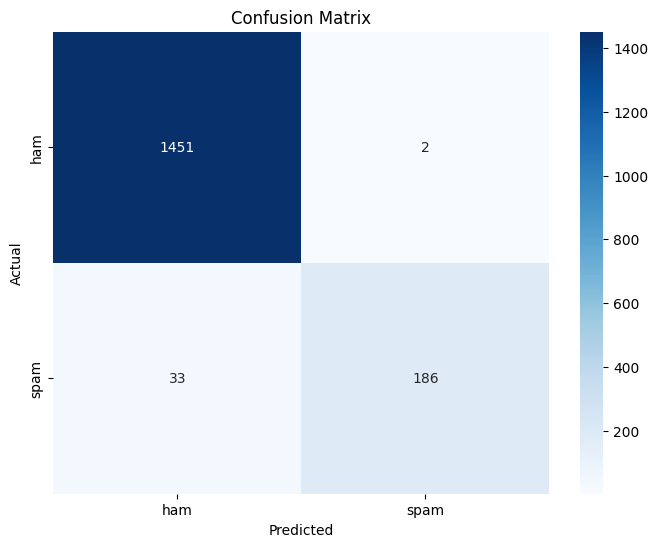

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Define class labels
class_names = ['ham', 'spam']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




In [22]:
# Generate classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1453
        spam       0.99      0.85      0.91       219

    accuracy                           0.98      1672
   macro avg       0.98      0.92      0.95      1672
weighted avg       0.98      0.98      0.98      1672



### Linear discriminant analysis

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Assuming you have your DataFrame df with 'message' and 'label' columns
X = df['message']
y = df['label']

# Create a CountVectorizer instance
count_vectorizer = CountVectorizer()

# Fit the CountVectorizer to the data and transform the data into a Bag of Words representation
X_bow = count_vectorizer.fit_transform(X)

# Get the feature names (words) in the vocabulary
bow_features = count_vectorizer.get_feature_names_out()

# Convert the Bag of Words representation into a DataFrame
X_bow_df = pd.DataFrame(X_bow.toarray(), columns=bow_features)

# Concatenate X_bow_df with the 'label' column from df
merged_df = pd.concat([X_bow_df, df['label']], axis=1)
merged_df

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,ìï,û_thanks,ûªm,ûªt,ûªve,ûï,ûïharry,ûò,ûówell,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spam
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spam
5568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham


In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


X = merged_df.drop(columns=['label']).values
y_numerical = merged_df['label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_numerical, test_size=0.3, random_state=42)

# Perform Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)




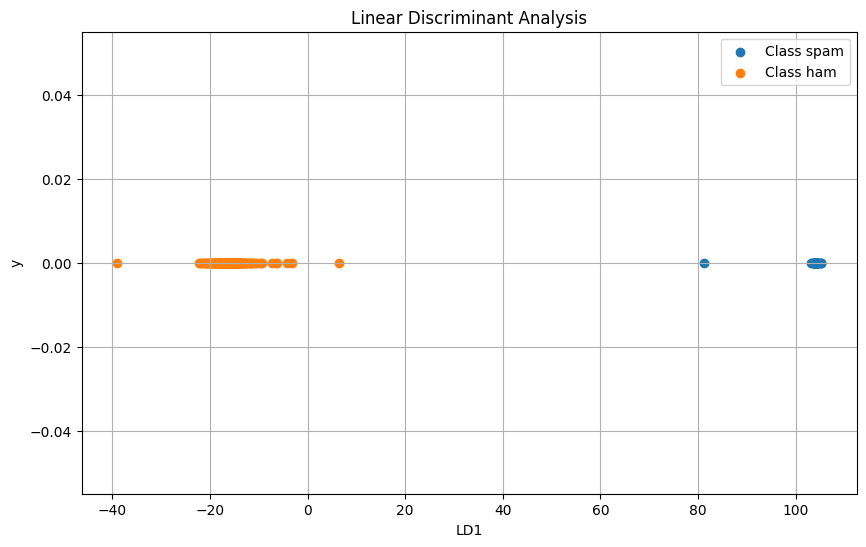

In [25]:
# Manually plot the classes along the first discriminant axis
plt.figure(figsize=(10, 6))
for label_value in set(y_train):
    X_lda_label = X_train_lda[y_train == label_value]
    plt.scatter(X_lda_label, [0] * len(X_lda_label), label=f'Class {label_value}')

plt.xlabel('LD1')
plt.ylabel('y')
plt.title('Linear Discriminant Analysis')
plt.legend()
plt.grid(True)
plt.show()

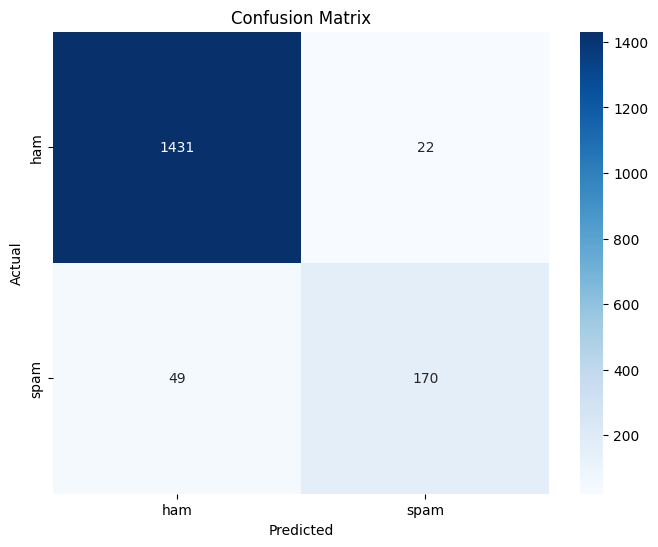

In [26]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Train SVM classifier on the LDA-transformed data
svm = SVC(kernel='linear')
svm.fit(X_train_lda, y_train)

# Make predictions on the LDA-transformed test data
y_pred = svm.predict(X_test_lda)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Define class labels
class_names = ['ham', 'spam']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [27]:
# Generate classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)



Classification Report:
              precision    recall  f1-score   support

         ham       0.97      0.98      0.98      1453
        spam       0.89      0.78      0.83       219

    accuracy                           0.96      1672
   macro avg       0.93      0.88      0.90      1672
weighted avg       0.96      0.96      0.96      1672

